In [1]:
import pandas as pd

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

import nltk

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
#nltk.download('stopwords')

morph = pymorphy2.MorphAnalyzer()

In [5]:
stopword_ru = stopwords.words('russian')

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-6-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 18.7 s, sys: 654 ms, total: 19.3 s
Wall time: 19.3 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 32s, sys: 48.4 ms, total: 2min 32s
Wall time: 2min 32s


In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 48.2 s, sys: 3min 51s, total: 4min 39s
Wall time: 36 s


In [11]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [12]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.60129285), (14, 0.08299154), (19, 0.19373512), (23, 0.09999798)]

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: смерть умереть армения испания скончаться испанский обнаружить
topic_1: рубль операция млн nn убийство размер данные
topic_2: россия российский газ nn экономика путин правительство
topic_3: статья гражданин nn космос налог следствие уголовный
topic_4: фонд депутат километр федеральный государственный медведев энергетика
topic_5: украина турция украинский турецкий европа киев россия
topic_6: наука область nn директор обнаружить рф кровь
topic_7: ракета запуск мышь собственность японский звёздный старт
topic_8: проект новый научный первый nn станция рынок
topic_9: тело планета мозг nn женщина помощь штат
topic_10: банк россиянин фсб белоруссия квартира округ палата
topic_11: ребёнок сша земля исследование всё университет выяснить
topic_12: кремль разместить мозг реформа фонд клинический снг
topic_13: доклад грузия орден уверять молдавия грузинский калинин
topic_14: день москва район рак nn обнаружить советский
topic_15: млн журнал тыс составить место nn вырасти
topic_16: млрд но

In [14]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.418699,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.030438,0.000000,0.0
1,4896,0.0,0.0,0.424045,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.095152,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.252911,0.0
2,4897,0.0,0.0,0.000000,0.0,0.000000,0.601247,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.193742,0.0,0.0,0.000000,0.100001,0.0
3,4898,0.0,0.0,0.000000,0.0,0.000000,0.129363,0.000000,0.0,0.081046,...,0.040658,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.081817,0.0
4,4899,0.0,0.0,0.000000,0.0,0.275639,0.000000,0.278612,0.0,0.276786,...,0.000000,0.0,0.0,0.0,0.088758,0.0,0.0,0.000000,0.000000,0.0


In [16]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [17]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [18]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.042749,0.134885,0.031813,0.005176,0.011444,0.051676,0.000000,0.062726,...,0.032022,0.009713,0.000000,0.0,0.063472,0.077773,0.050029,0.000000,0.004314,0.152327
1,u108690,0.001914,0.107819,0.127679,0.059051,0.010745,0.051129,0.025188,0.005118,0.021408,...,0.007358,0.027852,0.001863,0.0,0.003140,0.083793,0.006153,0.114081,0.000000,0.095286
2,u108339,0.000000,0.082427,0.109967,0.076945,0.005383,0.004075,0.071125,0.000000,0.046203,...,0.006090,0.047371,0.003023,0.0,0.000000,0.037660,0.078595,0.062182,0.003861,0.048510


In [19]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [20]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.042749,0.134885,0.031813,0.005176,0.011444,0.051676,0.000000,0.062726,...,0.009713,0.000000,0.0,0.063472,0.077773,0.050029,0.000000,0.004314,0.152327,0
1,u108690,0.001914,0.107819,0.127679,0.059051,0.010745,0.051129,0.025188,0.005118,0.021408,...,0.027852,0.001863,0.0,0.003140,0.083793,0.006153,0.114081,0.000000,0.095286,1
2,u108339,0.000000,0.082427,0.109967,0.076945,0.005383,0.004075,0.071125,0.000000,0.046203,...,0.047371,0.003023,0.0,0.000000,0.037660,0.078595,0.062182,0.003861,0.048510,1


In [21]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [22]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [23]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1326357 , 0.02001667, 0.46299531, 0.15198241, 0.02135358,
       0.01998915, 0.10589662, 0.00728584, 0.07709478, 0.09251328])

In [24]:
result = []

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.247702, F-Score=0.682, Precision=0.627, Recall=0.747


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1646  109]
 [  63  182]]


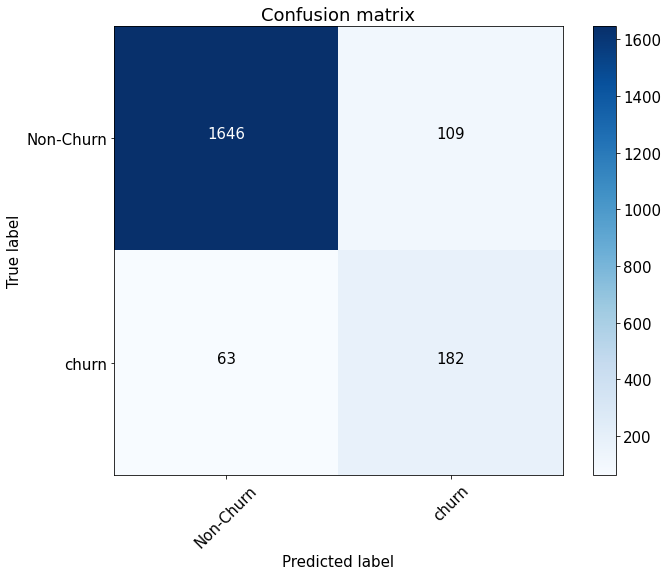

In [27]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [28]:
roc_auc_mean = roc_auc_score(y_test, preds)
result.append({"method":"mean","roc_auc" : roc_auc_mean, "fscore" : fscore[ix], "precision" : precision[ix], "recall" : recall[ix]})

#### Задание 1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [29]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [31]:
X = pd.merge(user_embeddings, target, 'left')

In [32]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [33]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [34]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05090809, 0.02100185, 0.76471627, 0.39966588, 0.01496622,
       0.01506122, 0.17831572, 0.00919311, 0.1498601 , 0.0871097 ])

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))



Best Threshold=0.270178, F-Score=0.852, Precision=0.807, Recall=0.902


Confusion matrix, without normalization
[[1702   53]
 [  25  220]]


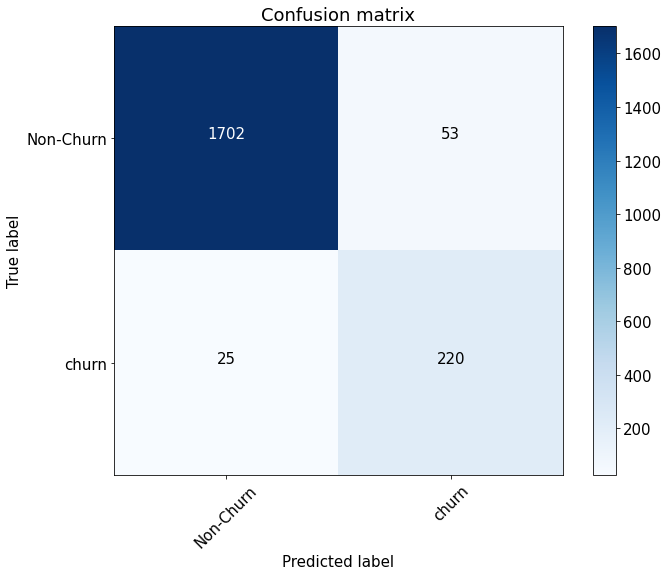

In [36]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
roc_auc_median = roc_auc_score(y_test, preds)
result.append({"method":"median","roc_auc" : roc_auc_median, "fscore" : fscore[ix], "precision" : precision[ix], "recall" : recall[ix]})

#### 2. Повторить п.2, но используя уже не медиану, а max

In [38]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [39]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [40]:
X = pd.merge(user_embeddings, target, 'left')

In [41]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [42]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [43]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([9.04565596e-02, 1.75811930e-04, 7.48539651e-01, 1.61174434e-01,
       9.18187167e-04, 1.05154555e-02, 1.41225645e-02, 5.41688735e-02,
       2.22790115e-02, 5.07792788e-02])

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.364738, F-Score=0.803, Precision=0.836, Recall=0.771


Confusion matrix, without normalization
[[1718   37]
 [  57  188]]


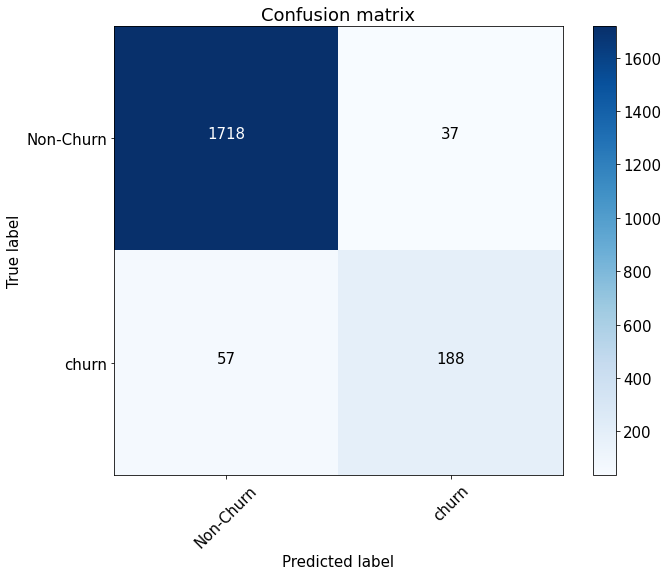

In [45]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [46]:
roc_auc_max = roc_auc_score(y_test, preds)
result.append({"method":"max","roc_auc" : roc_auc_max, "fscore" : fscore[ix], "precision" : precision[ix], "recall" : recall[ix]})

#### 3. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [49]:
pd.DataFrame(result)

,method,roc_auc,fscore,precision,recall
0,mean,0.949125,0.681564,0.626712,0.746939
1,median,0.986343,0.851638,0.806569,0.902041
2,max,0.974168,0.802548,0.836283,0.771429


#### 4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Медианный эмбендинг показал наиболее высокий результат, потому что медиана менее подвержена сильным перекосам и улавливает средние интересы пользователя. recall и fscore самый высокий 

Используя среднее пользователю показываются все категории новостей которые он смотрел , precision 0.62 из трех методов нахождения эмбендингов это самый маленький показатель. Среднее  плохо проявляет себя когда в данных есть выбросы.
Например пользователь смотрел новости по какой нибудь хайповой теме много раз и после у ного пропал интерес к данной теме, а модель все ровно будет показывать ему новости этой категории 

Максимальные эмбендинги хорошо проявляют себя потому что выбираются только те категории которые пользователю интересны, precision самый высокий.